In [115]:
from networks.pdhg_tgv import PdhgTgvTorch, PdhgTgvNumpy

In [116]:
from time import time

begin = time()
print(f"Importing torch ...")
import torch
print(f"torch imported in {time()-begin:.2f} seconds")

import numpy as np

Importing torch ...
torch imported in 0.00 seconds


In [117]:
def get_example_arrays():
    return (
        [
            [1, 2, 3], 
            [4, 5, 6], 
            [7, 8, 9]
        ],
        [
            [[1, 1], [2, 2], [3, 3]],
            [[4, 4], [5, 5], [6, 6]],
            [[7, 7], [8, 8], [9, 9]]
        ]
    )

In [118]:
# Example usage:
def test_pdhg_tgv_torch():
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    # u = torch.zeros((10, 10), device=device) # Assume 2D tensor of shape [n, n] (for now)
    # p = torch.zeros((10, 10, 2), device=device) # Assume 3D tensor of shape [n, n, 2] (for now)
    
    u, p = get_example_arrays()
    u = torch.tensor(u, device=device)
    p = torch.tensor(p, device=device)
    print(f"u.shape = {u.shape}, p.shape = {p.shape}")
    print(f"u = \n{u}")
    print(f"p = \n{p}")
    
    model = PdhgTgvTorch(device=device)

    uN = model(u, p, alpha1=0.5, alpha0=0.5, num_iters=3)
    print(uN)

test_pdhg_tgv_torch()

u.shape = torch.Size([3, 3]), p.shape = torch.Size([3, 3, 2])
u = 
tensor([[1, 2, 3],
        [4, 5, 6],
        [7, 8, 9]], device='cuda:0')
p = 
tensor([[[1, 1],
         [2, 2],
         [3, 3]],

        [[4, 4],
         [5, 5],
         [6, 6]],

        [[7, 7],
         [8, 8],
         [9, 9]]], device='cuda:0')
Using data-type-independent solver
tensor([[1.0000, 1.9623, 2.9327],
        [3.8868, 4.8491, 5.8195],
        [6.7980, 7.7603, 8.7307]], device='cuda:0')


In [119]:
def test_pdhg_tgv_numpy():
    # u = np.zeros((10, 10)) # Assume 2D tensor of shape [n, n] (for now)
    # p = np.zeros((10, 10, 2)) # Assume 3D tensor of shape [n, n, 2] (for now)
    u, p = get_example_arrays()
    u = np.array(u)
    p = np.array(p)
    print(f"u.shape = {u.shape}, p.shape = {p.shape}")
    print(f"u = \n{u}")
    print(f"p = \n{p}")
    model = PdhgTgvNumpy()
    
    uN = model.solve(u, p, alpha1=0.5, alpha0=0.5, num_iters=3)
    print(uN)
    
test_pdhg_tgv_numpy()

u.shape = (3, 3), p.shape = (3, 3, 2)
u = 
[[1 2 3]
 [4 5 6]
 [7 8 9]]
p = 
[[[1 1]
  [2 2]
  [3 3]]

 [[4 4]
  [5 5]
  [6 6]]

 [[7 7]
  [8 8]
  [9 9]]]
Using data-type-independent solver
[[1.         1.96226869 2.93267396]
 [3.88680608 4.84907477 5.81948004]
 [6.79802189 7.76029058 8.73069585]]


In [120]:
def test_pdhg_tgv_numpy_on_image():
    from PIL import Image
    import matplotlib.pyplot as plt

    img_path = "../../data/turtle_id_2022/turtles-data/data/images_crop_resize_256_greyscale_noisy_0_2/t008/PaXakrkxqN.JPG"

    img = Image.open(img_path)
    img = np.array(img, dtype=np.float32) / 255.0
    print(f"img.shape = {img.shape}")
    plt.imshow(img, cmap="gray")
    plt.title("Noisy image")
    plt.show()
    
    model = PdhgTgvNumpy()
    
    u = np.copy(img)
    p = np.zeros((img.shape[0], img.shape[1], 2))
    # p = np.copy(img)
    # p = p[..., np.newaxis]
    
    uN = model.solve(u, p, alpha1=0.3, alpha0=np.inf, num_iters=3)
    
    plt.imshow(uN, cmap="gray")
    plt.title("Denoised image")
    plt.show()

img.shape = (256, 256)


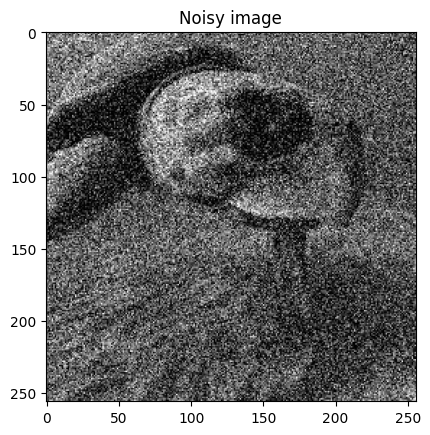

Using data-type-independent solver


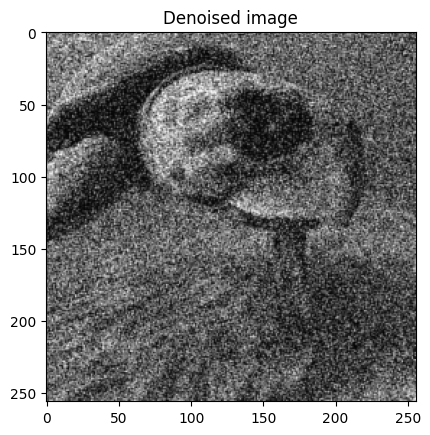

In [121]:
test_pdhg_tgv_numpy_on_image()